## MergeNet architecture

Multi-stage training with weight-sharing, learning separately the low and high-level features from RGBD input and fusing them in a refining stage.

Trained and evaluated on Lost and Found dataset.

Combining both appearance cues (RGB) and depth information performs better in identifying small obstacles and it is less sensitive to missinterpreting markings and zebra crossings as obstacles on the road (which could also cause a change in the image gradients) as obstacle edges.

MergeNet can be trained on small dataset (135 images) and still obtain promising results.

Contains 3 networks:
  - stripe-net: fully convolutional encoder-decoder trained with vertical strips of RGBD input
    - learns low-level features from vertical pathways of road images
    - shares parameters across stripes to reduce complexity and overfitting
  - context-net: also a fully convolutional encoder-decoder but trained on the whole image
    - learns high-level features from a wider region than a stripe-width
  - refiner-net: aggregate low- and high-level features and make the final prediction

The encoder & decoder blocks used for upsampling and downsampling the image is based on the Segnet network's architecture.
    - encoder: downsamples the input image through a series of convolutions, batch normalization and pooling layers
    - decoder: upsamples the encoded features through series of deconvolutions, batch normalization and unpooling layers until it re-obtains the original input resolution



In [1]:
import numpy as np
import pydot
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import os
import shutil
from packaging import version
import sklearn.metrics
import PIL.Image as Image
from keras.utils import to_categorical
import segmentation_models as sm
import math

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."

Segmentation Models: using `keras` framework.
TensorFlow version:  2.10.1


In [2]:
# test if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
print(tf.config.experimental.get_device_details(physical_devices[0]))
logical_devices = tf.config.list_logical_devices('GPU')
print(logical_devices)
GPU_NAME = logical_devices[0].name
print("logical GPU name = ", GPU_NAME)

{'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU', 'compute_capability': (8, 6)}
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
logical GPU name =  /device:GPU:0


## Load dataset

In [3]:
[train_ds, valid_ds, test_ds], info = tfds.load(name="lost_and_found/full",
                                                split=['train[:90%]', 'train[90%:]', 'test'], with_info=True)

In [4]:
train_ds.element_spec

{'disparity_map': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None),
 'image_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'image_left': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None),
 'image_right': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None),
 'instance_id': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None),
 'segmentation_label': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None)}

In [5]:
TRAIN_SIZE = train_ds.cardinality().numpy()
VALID_SIZE = valid_ds.cardinality().numpy()
TEST_SIZE = test_ds.cardinality().numpy()

print("Nr training instances = ", TRAIN_SIZE)
print("Nr validation instances = ", VALID_SIZE)
print("Nr test instances = ", TEST_SIZE)

Nr training instances =  932
Nr validation instances =  104
Nr test instances =  1203


In [6]:
BATCH_SIZE = 4
BATCH_SIZE_STRIPE = 32
NR_CLASSES = 3
ORIG_HEIGHT = 1024
ORIG_WIDTH = 2048
IMG_HEIGHT = 256
IMG_WIDTH = 896
K = 28

In [246]:
def add_sample_weights(mask, class_weights):
    return tf.gather(class_weights, indices=tf.cast(mask, tf.int32))


def preprocess_input(dataset, batch_size, buffer_size, reshuffle=False, class_weights=None):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=reshuffle)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    # add data augmentation
    # add sample weights
    if class_weights is not None:
        dataset = dataset.map(lambda img, mask: (img, mask, add_sample_weights(mask, class_weights)))
    dataset = dataset.prefetch(batch_size)
    return dataset


def process_images(x, img_shape):
    x = tf.image.resize(x, img_shape)
    # result of resizing will be a float tensor
    x = x / 255.0
    return x


def encode_label(x):
    x = tf.math.minimum(x, [2])
    return x


def process_labels(x, img_shape):
    x = tf.image.resize(x, img_shape, method='nearest')
    x = tf.map_fn(encode_label, x)
    return x


def process_img_stripes(x, img_shape, k):
    x = process_images(x, img_shape)
    # create k stripes of fixed width
    x = tf.split(x, num_or_size_splits=k, axis=1)
    return x


def process_label_stripes(x, img_shape, k):
    x = process_labels(x, img_shape)
    # create k stripes of fixed width
    x = tf.split(x, num_or_size_splits=k, axis=1)
    return x


def prepare_images(ds, img_shape):
    input = ds.map(lambda x: (x['image_left'], x['segmentation_label']))
    input = input.map(lambda x, y: (process_images(x, img_shape=img_shape),
                                    process_labels(y, img_shape=img_shape)))
    return input


# def prepare_mixed(ds, img_shape, k):
#     stripes_input = ds.map(lambda x: [(u, v) for u, v in
#                                                               zip(process_img_stripes(x['image_left'],
#                                                                                       img_shape=img_shape, k=k),
#                                                                   process_img_stripes(x['disparity_map'],
#                                                                                       img_shape=img_shape, k=k))])
#     images_input = ds.map(lambda x: process_images(x['image_left'], img_shape=img_shape))
#
#     labels_input = ds.map(lambda x: process_labels(x['segmentation_label'], img_shape=img_shape))
#
#     input = tf.data.Dataset.zip((stripes_input, images_input, labels_input))
#     input = input.map(lambda x,y,z: ((x,y),z))
#     return input

def prepare_mixed(ds, img_shape, k):
    input = ds.map(lambda x: (x['image_left'], x['disparity_map'], x['segmentation_label']))
    input = input.map(lambda x, y, z: (process_images(x, img_shape=img_shape),
                                       process_images(y, img_shape=img_shape),
                                       process_labels(z, img_shape=img_shape)))
    input = input.map(lambda x, y, z: ((x, y), z))
    return input


def prepare_stripes(ds, img_shape, k):
    input = ds.map(lambda x: (x['image_left'], x['disparity_map'], x['segmentation_label']))
    input = input.flat_map(
        lambda x, y, z: tf.data.Dataset.from_tensor_slices(((process_img_stripes(x, img_shape=img_shape, k=k),
                                                             process_img_stripes(y, img_shape=img_shape, k=k),
                                                             process_label_stripes(z, img_shape=img_shape, k=k)))))
    input = input.map(lambda x, y, z: ((x, y), z))
    return input

In [247]:
train_stripes = prepare_stripes(train_ds, [IMG_HEIGHT, IMG_WIDTH], K)
valid_stripes = prepare_stripes(valid_ds, [IMG_HEIGHT, IMG_WIDTH], K)
test_stripes = prepare_stripes(test_ds, [IMG_HEIGHT, IMG_WIDTH], K)

train_img = prepare_images(train_ds, [IMG_HEIGHT, IMG_WIDTH])
valid_img = prepare_images(valid_ds, [IMG_HEIGHT, IMG_WIDTH])
test_img = prepare_images(test_ds, [IMG_HEIGHT, IMG_WIDTH])

train_mix = prepare_mixed(train_ds, [IMG_HEIGHT, IMG_WIDTH], K)
valid_mix = prepare_mixed(valid_ds, [IMG_HEIGHT, IMG_WIDTH], K)
test_mix = prepare_mixed(test_ds, [IMG_HEIGHT, IMG_WIDTH], K)

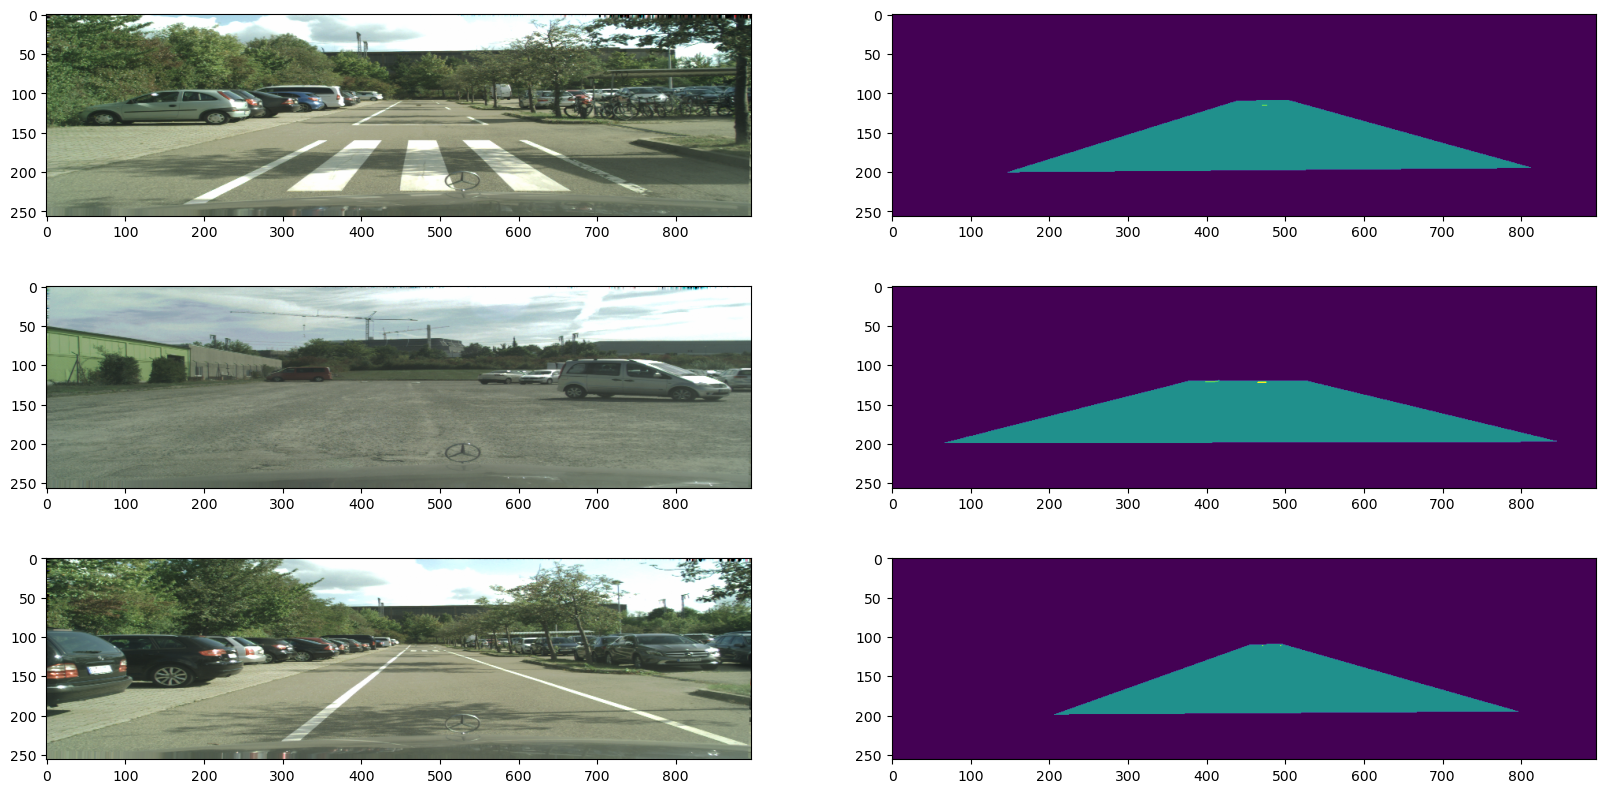

In [275]:
nr_samples = 3
fig, arr = plt.subplots(nr_samples, 2)
fig.set_figheight(10)
fig.set_figwidth(20)
i = 0
for img, label in train_img.as_numpy_iterator():
    arr[i, 0].imshow(img)
    arr[i, 1].imshow(label)
    i += 1
    if i >= nr_samples:
        break

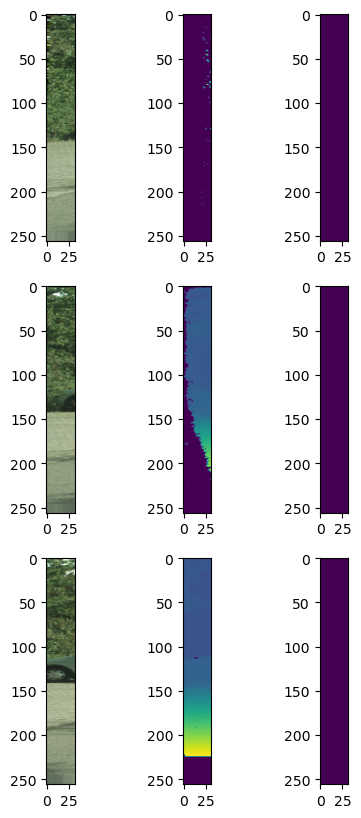

In [87]:
nr_samples = 3
fig, arr = plt.subplots(3, nr_samples)
fig.set_figheight(10)
fig.set_figwidth(5)
i = 0
for (img, depth), label in train_stripes.as_numpy_iterator():
    arr[i, 0].imshow(img)
    arr[i, 1].imshow(depth)
    arr[i, 2].imshow(label)
    i += 1
    if i >= nr_samples:
        break

## Build the models

In [9]:
def conv_layer(input, filters=64, kernel=(3, 3), activation_fct="relu"):
    conv = layers.Conv2D(filters, kernel, padding="same", input_shape=input.shape[1:])(input)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation(activation_fct)(conv)
    return conv


def encoder_decoder(input_shape,
                    filters,
                    kernel=(3, 3),
                    pool_size=(2, 2)):
    inputs = layers.Input(shape=input_shape)

    # encoder: 4 convolutional layers
    conv_1 = conv_layer(input=inputs, filters=filters, kernel=kernel, activation_fct="relu")
    pool_1 = layers.MaxPooling2D(pool_size)(conv_1)

    conv_2 = conv_layer(input=pool_1, filters=filters * 2, kernel=kernel, activation_fct="relu")
    pool_2 = layers.MaxPooling2D(pool_size)(conv_2)

    conv_3 = conv_layer(input=pool_2, filters=filters * 4, kernel=kernel, activation_fct="relu")
    pool_3 = layers.MaxPooling2D(pool_size)(conv_3)

    conv_4 = conv_layer(input=pool_3, filters=filters * 8, kernel=kernel, activation_fct="relu")
    pool_4 = layers.MaxPooling2D(pool_size)(conv_4)

    # decoder: 4 convolutional layers
    unpool_1 = layers.UpSampling2D(pool_size)(pool_4)
    conv_5 = conv_layer(input=unpool_1, filters=filters * 8, kernel=kernel, activation_fct="relu")

    unpool_2 = layers.UpSampling2D(pool_size)(conv_5)
    conv_6 = conv_layer(input=unpool_2, filters=filters * 4, kernel=kernel, activation_fct="relu")

    unpool_3 = layers.UpSampling2D(pool_size)(conv_6)
    conv_7 = conv_layer(input=unpool_3, filters=filters * 2, kernel=kernel, activation_fct="relu")

    unpool_4 = layers.UpSampling2D(pool_size)(conv_7)
    conv_8 = conv_layer(input=unpool_4, filters=filters, kernel=kernel, activation_fct="relu")

    model = keras.Model(inputs=inputs, outputs=conv_8)
    return model

In [10]:
def stripe_net(rgb_input_shape, depth_input_shape, nr_classes, k):
    rgb_enc_dec = encoder_decoder(input_shape=rgb_input_shape, filters=k // 4, kernel=(3, 3), pool_size=(2, 2))
    depth_enc_dec = encoder_decoder(input_shape=depth_input_shape, filters=k // 4, kernel=(3, 3), pool_size=(2, 2))
    concatenated = layers.Concatenate()([rgb_enc_dec.output, depth_enc_dec.output])
    output = layers.Conv2D(filters=nr_classes, kernel_size=(1, 1), padding="same", activation="softmax")(concatenated)
    model = keras.Model(inputs=[rgb_enc_dec.input, depth_enc_dec.input], outputs=output, name='stripe_net')
    return model

In [11]:
def context_net(rgb_input_shape, nr_classes):
    rgb_enc_dec = encoder_decoder(input_shape=rgb_input_shape, filters=8, kernel=(3, 3), pool_size=(2, 2))
    final_conv = layers.Conv2D(filters=nr_classes, kernel_size=3, activation="softmax", padding="same")(
        rgb_enc_dec.output)
    model = keras.Model(inputs=rgb_enc_dec.input, outputs=final_conv, name='context_net')
    return model

In [307]:
def refiner_net(rgb_input_shape, depth_input_shape, nr_stripes, nr_classes, filters=8, kernel=(3, 3), pool_size=(2, 2)):
    stripe_model = keras.models.load_model("models/stripe_net.h5")
    context_model = keras.models.load_model("models/context_net.h5")
    # freeze the weights of the outer models
    stripe_model.trainable = False
    context_model.trainable = False

    rgb_inputs = layers.Input(shape=rgb_input_shape)
    depth_inputs = layers.Input(shape=depth_input_shape)

    stripe_inputs = layers.Lambda(lambda x: [(a, b) for a, b in zip(tf.split(x[0], nr_stripes, axis=2), (tf.split(x[1], nr_stripes, axis=2)))]) ([rgb_inputs, depth_inputs])

    stripe_outputs = [stripe_model(si) for si in stripe_inputs]
    stripe_output = layers.Concatenate(axis=2) (stripe_outputs)

    context_output = context_model(rgb_inputs)

    partial_outputs = layers.Concatenate(axis=-1)([stripe_output, context_output])
    partial_outputs = layers.Conv2D(filters=3, kernel_size=(1, 1))(partial_outputs)

    conv_1 = conv_layer(input=partial_outputs, filters=filters, kernel=kernel, activation_fct="relu")
    pool_1 = layers.MaxPooling2D(pool_size)(conv_1)

    conv_2 = conv_layer(input=pool_1, filters=filters * 2, kernel=kernel, activation_fct="relu")
    pool_2 = layers.MaxPooling2D(pool_size)(conv_2)

    unpool_1 = layers.UpSampling2D(pool_size)(pool_2)
    conv_3 = conv_layer(input=unpool_1, filters=filters * 2, kernel=kernel, activation_fct="relu")

    unpool_2 = layers.UpSampling2D(pool_size)(conv_3)
    conv_4 = conv_layer(input=unpool_2, filters=filters, kernel=kernel, activation_fct="relu")

    output = layers.Conv2D(filters=nr_classes, kernel_size=3, activation="softmax", padding="same", name="final_conv")(
        conv_4)

    model = keras.Model(inputs=[rgb_inputs, depth_inputs], outputs=output, name='refiner_net')
    return model

In [322]:
def add_argmax_layer(model):
    enhanced_model = layers.Lambda(lambda x: tf.expand_dims(tf.cast(tf.math.argmax(x, axis=-1), 'uint8'), axis=-1))(
        model.output)
    return enhanced_model

## Train the models

### Stripe-net

In [14]:
EPOCHS = 20
BATCH_SIZE_STRIPE = 32
train_stripes_batch = preprocess_input(train_stripes, BATCH_SIZE_STRIPE, buffer_size=TRAIN_SIZE, reshuffle=True)
valid_stripes_batch = preprocess_input(valid_stripes, BATCH_SIZE_STRIPE, buffer_size=VALID_SIZE, reshuffle=True)

In [643]:
stripe_net_model = stripe_net(rgb_input_shape=(IMG_HEIGHT, IMG_WIDTH // K, 3),
                              depth_input_shape=(IMG_HEIGHT, IMG_WIDTH // K, 1),
                              nr_classes=NR_CLASSES,
                              k=K)
print(stripe_net_model.summary())

Model: "stripe_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_115 (InputLayer)         [(None, 256, 32, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_116 (InputLayer)         [(None, 256, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_734 (Conv2D)            (None, 256, 32, 7)   196         ['input_115[0][0]']              
                                                                                         

In [644]:
stripe_net_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                         metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [645]:
earlystopper = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint("models/stripe_net.h5", monitor='val_loss', verbose=1, save_best_only=True,
                                             mode='min')
stripe_net_history = stripe_net_model.fit(train_stripes_batch,
                                          batch_size=BATCH_SIZE_STRIPE,
                                          epochs=EPOCHS,
                                          shuffle=True,
                                          steps_per_epoch=TRAIN_SIZE * K // BATCH_SIZE_STRIPE,
                                          validation_steps=VALID_SIZE * K // BATCH_SIZE_STRIPE,
                                          callbacks=[earlystopper, checkpoint],
                                          validation_data=valid_stripes_batch)

Epoch 1/20
815/815 [==============================] - ETA: 0s - loss: 0.1121 - sparse_categorical_accuracy: 0.9557
Epoch 1: val_loss improved from inf to 0.37121, saving model to models\stripe_net.h5
815/815 [==============================] - 45s 49ms/step - loss: 0.1121 - sparse_categorical_accuracy: 0.9557 - val_loss: 0.3712 - val_sparse_categorical_accuracy: 0.9135
Epoch 2/20
815/815 [==============================] - ETA: 0s - loss: 0.0823 - sparse_categorical_accuracy: 0.9663
Epoch 2: val_loss improved from 0.37121 to 0.15996, saving model to models\stripe_net.h5
815/815 [==============================] - 25s 30ms/step - loss: 0.0823 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.1600 - val_sparse_categorical_accuracy: 0.9427
Epoch 3/20
814/815 [============================>.] - ETA: 0s - loss: 0.0743 - sparse_categorical_accuracy: 0.9697
Epoch 3: val_loss did not improve from 0.15996
815/815 [==============================] - 24s 30ms/step - loss: 0.0743 - sparse_categorical

In [235]:
def plot_history(history, metric):
    plt.plot(history[metric])
    plt.plot(history['val_' + metric])
    plt.title('Model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [619]:
print(stripe_net_history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


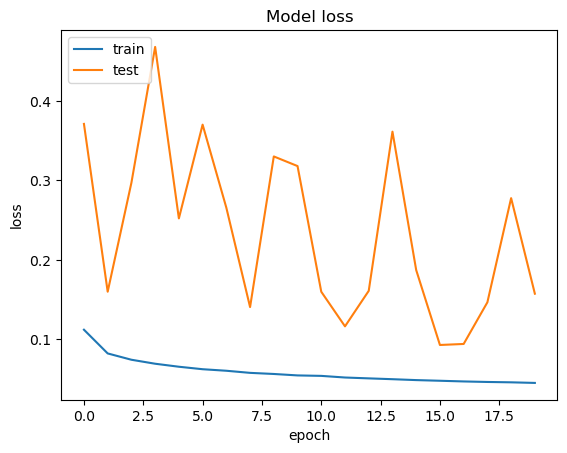

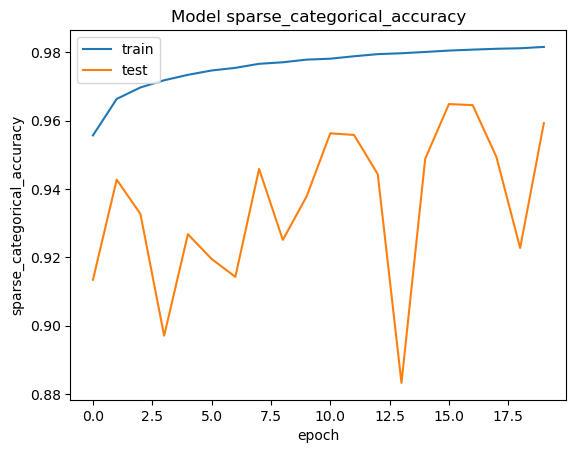

In [646]:
plot_history(stripe_net_history.history, 'loss')
plot_history(stripe_net_history.history, 'sparse_categorical_accuracy')

1/1 [==============================] - 4s 4s/step


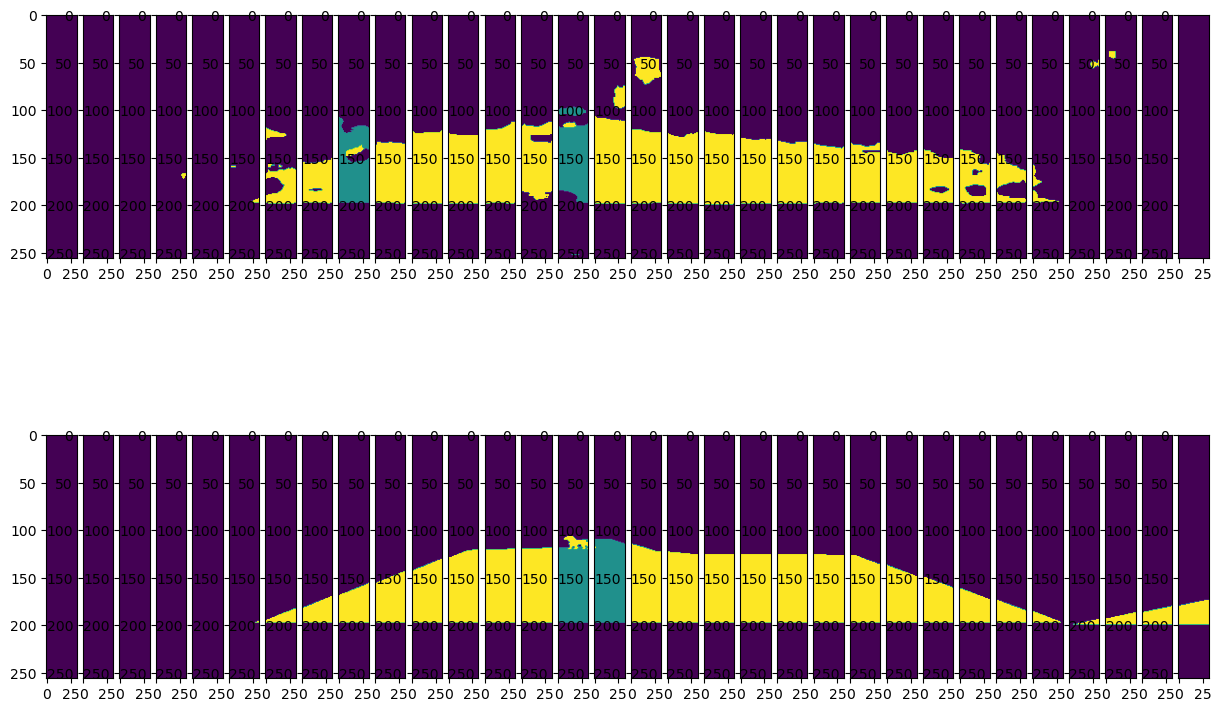

In [647]:
for x, label in test_stripes.batch(BATCH_SIZE_STRIPE).as_numpy_iterator():
    pred_mask = stripe_net_model.predict(x)
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(2, BATCH_SIZE_STRIPE)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    for i in range(BATCH_SIZE_STRIPE):
        arr[0, i].imshow(pred_mask[i])
        arr[1, i].imshow(label[i])
    break

### Context-net

In [586]:
def count_pixels(x, label):
    x = x.flatten()
    return np.sum([x == label])


def compute_class_weights(ds):
    for _, mask in ds.as_numpy_iterator():
        nr_background_pixels = count_pixels(mask, 0)
        nr_road_pixels = count_pixels(mask, 1)
        nr_obstacle_pixels = count_pixels(mask, 2)
        print("background : road : obstacle =", nr_background_pixels, ":", nr_road_pixels, ":", nr_obstacle_pixels)
        total_pixels = nr_background_pixels + nr_road_pixels + nr_obstacle_pixels
        # class weights are inversely proportional with the ratio of pixels of given class vs total pixels
        weights = [total_pixels / nr_background_pixels, total_pixels / nr_road_pixels,
                   total_pixels / nr_obstacle_pixels]
        weights = np.asarray(weights) / NR_CLASSES
        return weights

In [587]:
train_weights = compute_class_weights(train_img.batch(BATCH_SIZE))
print("Training weights:", train_weights)
valid_weights = compute_class_weights(valid_img.batch(BATCH_SIZE))
print("Validation weights:", valid_weights)

background : road : obstacle = 773886 : 143145 : 473
Training weights: [3.95193435e-01 2.13653754e+00 6.46584919e+02]
background : road : obstacle = 756067 : 160805 : 632
Validation weights: [4.04507361e-01 1.90189774e+00 4.83915612e+02]


In [649]:
EPOCHS = 20
BATCH_SIZE = 4
train_img_batch = preprocess_input(train_img, BATCH_SIZE, buffer_size=TRAIN_SIZE, class_weights=train_weights)
valid_img_batch = preprocess_input(valid_img, BATCH_SIZE, buffer_size=VALID_SIZE, class_weights=valid_weights)

In [682]:
context_net_model = context_net(rgb_input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                nr_classes=NR_CLASSES)
print(context_net_model.summary())

Model: "context_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_678 (InputLayer)      [(None, 256, 896, 3)]     0         
                                                                 
 conv2d_5540 (Conv2D)        (None, 256, 896, 8)       224       
                                                                 
 batch_normalization_5168 (B  (None, 256, 896, 8)      32        
 atchNormalization)                                              
                                                                 
 activation_5168 (Activation  (None, 256, 896, 8)      0         
 )                                                               
                                                                 
 max_pooling2d_2584 (MaxPool  (None, 128, 448, 8)      0         
 ing2D)                                                          
                                                       

In [683]:
context_net_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
                          metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [652]:
earlystopper = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint("models/context_net.h5", monitor='val_loss', verbose=1,
                                             save_best_only=True, mode='min')

context_net_history = context_net_model.fit(train_img_batch,
                                            batch_size=BATCH_SIZE,
                                            epochs=EPOCHS,
                                            steps_per_epoch=TRAIN_SIZE // BATCH_SIZE,
                                            callbacks=[earlystopper, checkpoint],
                                            validation_steps=VALID_SIZE // BATCH_SIZE,
                                            validation_data=valid_img_batch)

Epoch 1/20
233/233 [==============================] - ETA: 0s - loss: 0.8923 - sparse_categorical_accuracy: 0.5673 - weighted_sparse_categorical_accuracy: 0.7612
Epoch 1: val_loss improved from inf to 2.58963, saving model to models\context_net.h5
233/233 [==============================] - 53s 74ms/step - loss: 0.8923 - sparse_categorical_accuracy: 0.5673 - weighted_sparse_categorical_accuracy: 0.7612 - val_loss: 2.5896 - val_sparse_categorical_accuracy: 0.4215 - val_weighted_sparse_categorical_accuracy: 0.5885
Epoch 2/20
233/233 [==============================] - ETA: 0s - loss: 0.6635 - sparse_categorical_accuracy: 0.6604 - weighted_sparse_categorical_accuracy: 0.8244
Epoch 2: val_loss improved from 2.58963 to 0.87073, saving model to models\context_net.h5
233/233 [==============================] - 13s 58ms/step - loss: 0.6635 - sparse_categorical_accuracy: 0.6604 - weighted_sparse_categorical_accuracy: 0.8244 - val_loss: 0.8707 - val_sparse_categorical_accuracy: 0.7549 - val_weighte

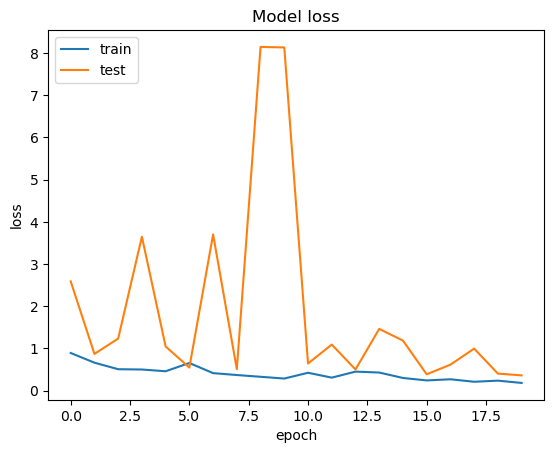

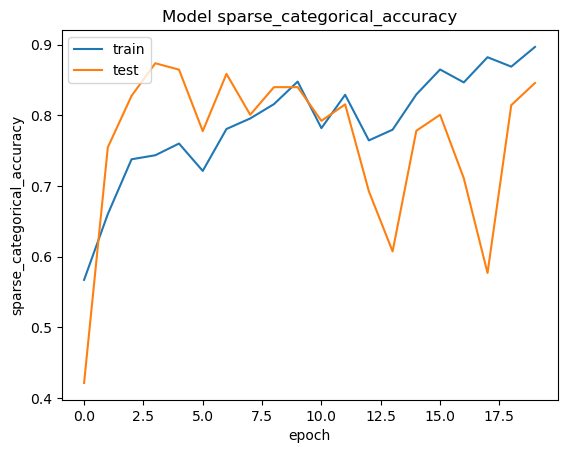

In [653]:
plot_history(context_net_history.history, 'loss')
plot_history(context_net_history.history, 'sparse_categorical_accuracy')

1/1 [==============================] - 2s 2s/step


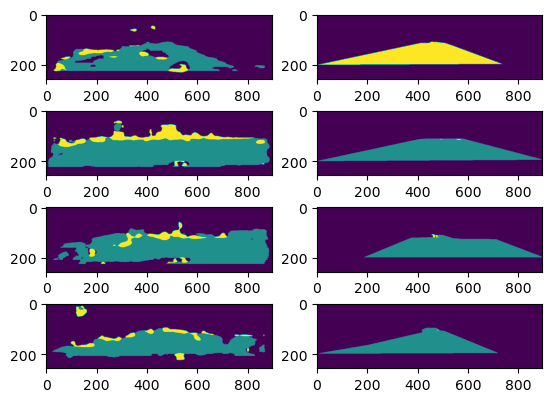

In [654]:
for x, label in test_img.shuffle(BATCH_SIZE).batch(BATCH_SIZE).as_numpy_iterator():
    pred_mask = context_net_model.predict(x)
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(BATCH_SIZE, 2)
    for i in range(BATCH_SIZE):
        arr[i, 0].imshow(pred_mask[i])
        arr[i, 1].imshow(label[i])
    break

## Refiner-net

In [250]:
EPOCHS = 20
BATCH_SIZE = 4
train_input_mix = preprocess_input(train_mix, batch_size=BATCH_SIZE, buffer_size=TRAIN_SIZE)
valid_input_mix = preprocess_input(valid_mix, batch_size=BATCH_SIZE, buffer_size=VALID_SIZE)
train_input_mix.element_spec

((TensorSpec(shape=(None, 256, 896, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 256, 896, 1), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 256, 896, 1), dtype=tf.uint8, name=None))

In [317]:
refiner_net_model = refiner_net(rgb_input_shape=[IMG_HEIGHT, IMG_WIDTH, 3],
                                depth_input_shape=[IMG_HEIGHT, IMG_WIDTH, 1],
                                nr_stripes=K,
                                nr_classes=NR_CLASSES)

In [313]:
print("Input shape:", refiner_net_model.input_shape)
print("Output shape:", refiner_net_model.output_shape)

Input shape: [(None, 256, 896, 3), (None, 256, 896, 1)]
Output shape: (None, 256, 896, 3)


In [318]:
refiner_net_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
                          metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [319]:
filepath = "models/refiner_net.h5"
earlystopper = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                             save_best_only=True, mode='min')

refiner_net_history = refiner_net_model.fit(train_input_mix,
                                            batch_size=BATCH_SIZE,
                                            epochs=EPOCHS,
                                            steps_per_epoch=TRAIN_SIZE // BATCH_SIZE,
                                            callbacks=[earlystopper, checkpoint],
                                            validation_steps=VALID_SIZE // BATCH_SIZE,
                                            validation_data=valid_input_mix)

Epoch 1/20
233/233 [==============================] - ETA: 0s - loss: 0.0850 - sparse_categorical_accuracy: 0.9681 - weighted_sparse_categorical_accuracy: 0.9681
Epoch 1: val_loss improved from inf to 0.18964, saving model to models\refiner_net.h5
233/233 [==============================] - 56s 161ms/step - loss: 0.0850 - sparse_categorical_accuracy: 0.9681 - weighted_sparse_categorical_accuracy: 0.9681 - val_loss: 0.1896 - val_sparse_categorical_accuracy: 0.9717 - val_weighted_sparse_categorical_accuracy: 0.9717
Epoch 2/20
233/233 [==============================] - ETA: 0s - loss: 0.0678 - sparse_categorical_accuracy: 0.9729 - weighted_sparse_categorical_accuracy: 0.9729
Epoch 2: val_loss improved from 0.18964 to 0.15501, saving model to models\refiner_net.h5
233/233 [==============================] - 32s 136ms/step - loss: 0.0678 - sparse_categorical_accuracy: 0.9729 - weighted_sparse_categorical_accuracy: 0.9729 - val_loss: 0.1550 - val_sparse_categorical_accuracy: 0.9697 - val_weigh

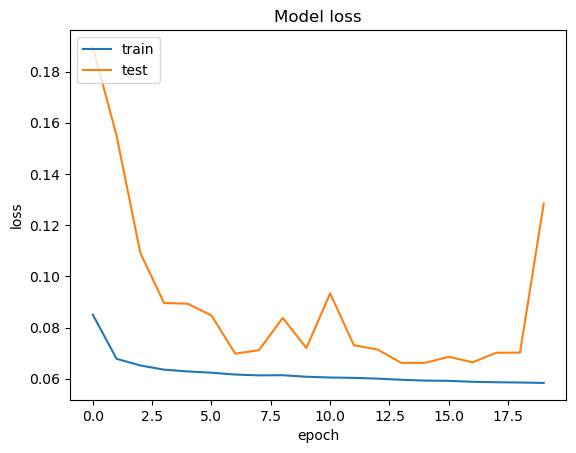

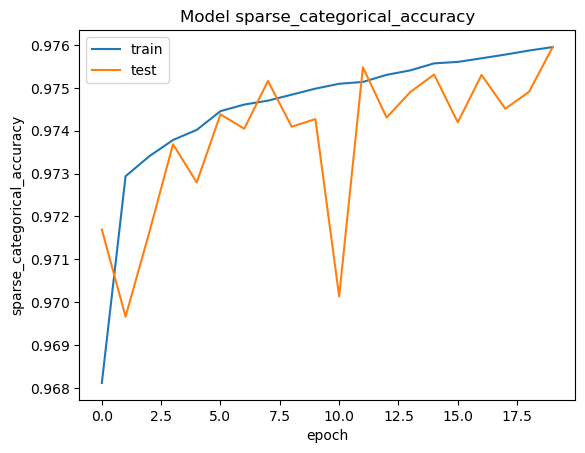

In [320]:
plot_history(refiner_net_history.history, 'loss')
plot_history(refiner_net_history.history, 'sparse_categorical_accuracy')

In [323]:
merge_net_model = add_argmax_layer(refiner_net_model)

1/1 [==============================] - 0s 358ms/step


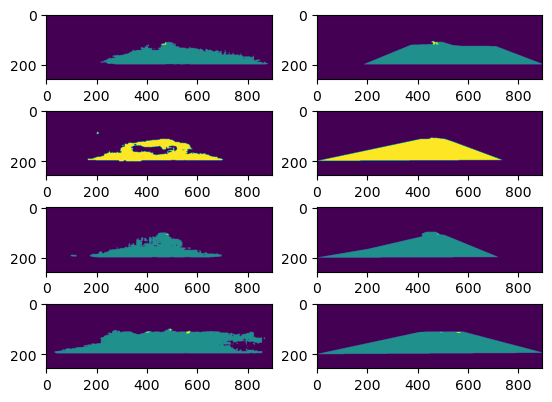

In [330]:
for x, y in test_mix.batch(BATCH_SIZE).as_numpy_iterator():
    pred_mask = refiner_net_model.predict(x)
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(BATCH_SIZE, 2)
    for i in range(BATCH_SIZE):
        arr[i, 0].imshow(pred_mask[i])
        arr[i, 1].imshow(y[i])
    break